In [1]:
# https://deeplearningcourses.com/c/unsupervised-deep-learning-in-python
# https://www.udemy.com/unsupervised-deep-learning-in-python
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture

In [2]:
def relu(x):
    return x * (x > 0)


def error_rate(p, t):
    return np.mean(p != t)


def getKaggleMNIST():
    # MNIST data:
    # column 0 is labels
    # column 1-785 is data, with values 0 .. 255
    # total size of CSV: (42000, 1, 28, 28)
    train = pd.read_csv('us_data/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000,1:] / 255
    Ytrain = train[:-1000,0].astype(np.int32)

    Xtest  = train[-1000:,1:] / 255
    Ytest  = train[-1000:,0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest


def init_weights(shape):
    return np.random.randn(*shape) / np.sqrt(sum(shape))

In [3]:
def purity(Y, R):
    # maximum purity is 1, higher is better

    N, K = R.shape
    p = 0
    for k in range(K):
        best_target = -1 # we don't strictly need to store this
        max_intersection = 0
        for j in range(K):
            intersection = R[Y==j, k].sum()
            if intersection > max_intersection:
                max_intersection = intersection
                best_target = j
        p += max_intersection
    return p / N

In [4]:
class Layer(object):
    def __init__(self, m1, m2):
        W = init_weights((m1, m2))
        bi = np.zeros(m2)
        bo = np.zeros(m1)
        self.W = theano.shared(W)
        self.bi = theano.shared(bi)
        self.bo = theano.shared(bo)
        self.params = [self.W, self.bi, self.bo]

    def forward(self, X):
        return T.nnet.sigmoid(X.dot(self.W) + self.bi)

    def forwardT(self, X):
        return T.nnet.sigmoid(X.dot(self.W.T) + self.bo)


In [13]:
class DeepAutoEncoder(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=50, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = int(N / batch_sz)

        mi = D
        self.layers = []
        self.params = []
        for mo in self.hidden_layer_sizes:
            layer = Layer(mi, mo)
            self.layers.append(layer)
            self.params += layer.params
            mi = mo

        X_in = T.matrix('X')
        X_hat = self.forward(X_in)

        cost = -(X_in * T.log(X_hat) + (1 - X_in) * T.log(1 - X_hat)).mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,
        )

        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        grads = T.grad(cost, self.params)

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]
        train_op = theano.function(
            inputs=[X_in],
            outputs=cost,
            updates=updates,
        )

        costs = []
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                c = train_op(batch)
                if j % 100 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)

        self.map2center = theano.function(
            inputs=[X],
            outputs=Z,
        )

        for i in range(len(self.layers)-1, -1, -1):
            Z = self.layers[i].forwardT(Z)

        return Z

epoch: 0
j / n_batches: 0 / 410 cost: 0.704806765742393
j / n_batches: 100 / 410 cost: 0.2744896180794323
j / n_batches: 200 / 410 cost: 0.261477182997705
j / n_batches: 300 / 410 cost: 0.26818639020834517
j / n_batches: 400 / 410 cost: 0.2528241681010859
epoch: 1
j / n_batches: 0 / 410 cost: 0.2648083502874967
j / n_batches: 100 / 410 cost: 0.2649343694330339
j / n_batches: 200 / 410 cost: 0.2633155483961712
j / n_batches: 300 / 410 cost: 0.24422677082707253
j / n_batches: 400 / 410 cost: 0.24205202333814949
epoch: 2
j / n_batches: 0 / 410 cost: 0.2552401180971918
j / n_batches: 100 / 410 cost: 0.24949746175442328
j / n_batches: 200 / 410 cost: 0.25033300940590564
j / n_batches: 300 / 410 cost: 0.2444417183213358
j / n_batches: 400 / 410 cost: 0.23778370300084015
epoch: 3
j / n_batches: 0 / 410 cost: 0.23964630666868314
j / n_batches: 100 / 410 cost: 0.2431682779555422
j / n_batches: 200 / 410 cost: 0.23652076611475067
j / n_batches: 300 / 410 cost: 0.2434455173824756
j / n_batches: 4

j / n_batches: 200 / 410 cost: 0.1798957627364903
j / n_batches: 300 / 410 cost: 0.19107588349466123
j / n_batches: 400 / 410 cost: 0.19283241751790373
epoch: 32
j / n_batches: 0 / 410 cost: 0.1788590018114795
j / n_batches: 100 / 410 cost: 0.18158748985416048
j / n_batches: 200 / 410 cost: 0.1858252914719406
j / n_batches: 300 / 410 cost: 0.1837101029413481
j / n_batches: 400 / 410 cost: 0.18967748136747012
epoch: 33
j / n_batches: 0 / 410 cost: 0.18583455256265055
j / n_batches: 100 / 410 cost: 0.18195647493131278
j / n_batches: 200 / 410 cost: 0.18194064824938982
j / n_batches: 300 / 410 cost: 0.19731251630131202
j / n_batches: 400 / 410 cost: 0.19018921056362942
epoch: 34
j / n_batches: 0 / 410 cost: 0.19405304381046615
j / n_batches: 100 / 410 cost: 0.1878356626522889
j / n_batches: 200 / 410 cost: 0.179265099780106
j / n_batches: 300 / 410 cost: 0.18342250005536384
j / n_batches: 400 / 410 cost: 0.1759104612652468
epoch: 35
j / n_batches: 0 / 410 cost: 0.17392925504437218
j / n_b

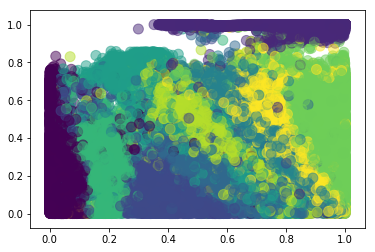

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
dae = DeepAutoEncoder([500, 300, 2])
dae.fit(Xtrain)
mapping = dae.map2center(Xtrain)
plt.scatter(mapping[:,0], mapping[:,1], c=Ytrain, s=100, alpha=0.5)
plt.show()

# purity measure from unsupervised machine learning pt 1
gmm = GaussianMixture(n_components=10)
gmm.fit(Xtrain)
responsibilities_full = gmm.predict_proba(Xtrain)
print("full purity:", purity(Ytrain, responsibilities_full))

gmm.fit(mapping)
responsibilities_reduced = gmm.predict_proba(mapping)
print("reduced purity:", purity(Ytrain, responsibilities_reduced))